In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

2025-09-08 14:01:51.360 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/groot/Projects/athletes_brain


In [2]:
# Initialize configuration
config = Fig1Config()

config.METRICS = ["gm_vol", "adc"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol', 'adc']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


In [3]:
FORCE = False
# Generate complete Figure 1
# output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "learners"
output_dir = Path("/media//groot/Minerva/phd") / "athletes_brain" / "figures" / "climbers"
# generate_figure1(output_dir=output_dir, config=config)

In [4]:
# Initialize data loader
data_loader = AthletesBrainDataLoader(config)

# Load all data
metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

print(f"Loaded {len(metric_data)} metrics")
print(f"Loaded {len(parcels)} brain parcels")
print(f"Metrics: {list(metric_data.keys())}")

metric_data = {
    key: val.drop(val[(~val["cs_valid"]) & ~val["learner"]].index)
    for key, val in metric_data.items()
}

# Display sample data (demographics)
d = metric_data["gm_vol"].drop_duplicates(subset=["subject_code"], keep="first")
print(f"Total N participants: {d.shape[0]}")
athletes = d[d["target"]]
climbers = athletes[athletes["group"] == config.CLIMBER_GROUP_LABEL]
bjjers = athletes[athletes["group"] == config.BJJ_GROUP_LABEL]

learners = d[d["learner"]]
climbers_learners = learners[learners["group"] == config.CLIMBER_GROUP_LABEL]
bjjers_learners = learners[learners["group"] == config.BJJ_GROUP_LABEL]

print(f"Total N athletes: {athletes.shape[0]}")
print(f"Total N climbers: {climbers.shape[0]}")
print(f"Total N BJJ practitioners: {bjjers.shape[0]}")
print(f"Total N learners: {learners.shape[0]}")
print(f"Total N climbers (learners): {climbers_learners.shape[0]}")
print(f"Total N BJJ practitioners (learners): {bjjers_learners.shape[0]}")

2025-09-08 14:01:52.811 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:48 - Loading metric data...
2025-09-08 14:01:52.811 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading gm_vol data


/home/groot/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (1,6,7,8,9,10,11,12,68,74,78,79,80,81,82,84,85,86,87,92,93,94,95,96,97,99,113,115,116,121,122,123,124,125,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-09-08 14:02:13.301 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 1595356 records for gm_vol
2025-09-08 14:02:13.301 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading adc data


/home/groot/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (16,23,24,25,26,27,33,39,43,44,45,46,47,49,50,51,52,57,58,59,60,61,62,64,78,80,81,86,87,88,89,96,97,98,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-09-08 14:02:28.681 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 1600350 records for adc
2025-09-08 14:02:28.681 | SUCCESS  | athletes_brain.fig1.data_loader:load_metric_data:84 - Successfully loaded 2 metrics
2025-09-08 14:02:28.681 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:32 - Loading atlas data for schaefer2018tian2020_400_7
2025-09-08 14:02:28.683 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:39 - Loaded 454 parcels from atlas
Loaded 2 metrics
Loaded 454 brain parcels
Metrics: ['gm_vol', 'adc']
Total N participants: 1682
Total N athletes: 139
Total N climbers: 80
Total N BJJ practitioners: 51
Total N learners: 239
Total N climbers (learners): 116
Total N BJJ practitioners (learners): 99


In [33]:
from athletes_brain.config import EXTERNAL_DATA_DIR


skill_assessment = pd.read_csv(EXTERNAL_DATA_DIR / "sessions_climbing.csv")

In [38]:
import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from numpy.linalg import LinAlgError
from tqdm import tqdm


def _get_beta_and_vcov(res):
    """
    Return (beta_vec, vcov_mat, names_list) for fixed effects only,
    across MixedLM and OLS (incl. cluster-robust wrappers).
    """
    # Preferred path for MixedLM: use fixed effects only
    fe = getattr(res, "fe_params", None)
    if isinstance(fe, pd.Series):
        P = fe.values.astype(float)
        Vfull = res.cov_params()
        if isinstance(Vfull, pd.DataFrame):
            V = Vfull.loc[fe.index, fe.index].values
        else:
            V = np.asarray(Vfull)[: len(P), : len(P)]
        names = list(fe.index)
        return P, V, names

    # Generic path (OLS etc.)
    P = getattr(res, "params", None)
    V = res.cov_params()
    # names
    try:
        names = list(res.model.exog_names)
    except Exception:
        names = None

    if isinstance(P, pd.Series):
        names = list(P.index) if names is None else names
        P = P.values.astype(float)
    else:
        P = np.asarray(P, dtype=float).ravel()
        if names is None:
            names = [f"x{i}" for i in range(len(P))]

    V = V.values if isinstance(V, pd.DataFrame) else np.asarray(V, dtype=float)
    return P, V, names


def lincom(res, coefs, *, warn_missing=False):
    """
    Linear combo on a statsmodels result.
    coefs: dict {param_name: weight}
    Returns: (est, se, z, p, lo, hi)
    """
    P, V, names = _get_beta_and_vcov(res)
    name_to_idx = {n: i for i, n in enumerate(names)}
    L = np.zeros_like(P, dtype=float)

    missing = []
    for name, w in coefs.items():
        if name in name_to_idx:
            L[name_to_idx[name]] = w
        else:
            missing.append(name)

    if warn_missing and missing:
        print(f"[lincom] Missing params (treated as 0): {missing}\nAvailable: {names}")

    est = float(L @ P)
    var = float(L @ V @ L)
    se = np.sqrt(max(var, 0.0))
    z = est / se if se > 0 else np.nan
    # two-sided normal p:
    p = 2 * 0.5 * math.erfc(abs(z) / np.sqrt(2)) if se > 0 else np.nan
    lo, hi = est - 1.96 * se, est + 1.96 * se
    return est, se, z, p, lo, hi


def _sex_term(d):
    return " + C(sex)" if ("sex" in d.columns and d["sex"].nunique() > 1) else ""


def _tiv_term(metric: str):
    return " + tiv" if "vol" in str(metric).lower() else ""


def add_scaled_covariates(d: pd.DataFrame, metric: str) -> pd.DataFrame:
    d = d.copy()
    # Age: center, then square the centered term
    if "age_at_scan" in d.columns:
        d["age_c"] = d["age_at_scan"] - d["age_at_scan"].mean()
        d["age_c2"] = d["age_c"] ** 2
    else:
        d["age_c"] = d["age_c2"] = 0.0

    # TIV: z-score if present and used for 'vol' metrics
    if "tiv" in d.columns and "vol" in str(metric).lower():
        sd = d["tiv"].std(ddof=0)
        d["tiv_z"] = (d["tiv"] - d["tiv"].mean()) / (sd if sd and sd > 0 else 1.0)
    # else:
    #     d["tiv_z"] = 0.0

    return d


# ---------- primary Athlete vs Learner model ----------
def fit_roi_model(d, metric: str, time_variable: str = "time_months"):
    d = add_scaled_covariates(d, metric)
    d["condition"] = pd.Categorical(d["condition"], categories=["Athlete", "Learner"])
    if "sex" in d:
        d["sex"] = d["sex"].astype("category")

    if d["condition"].nunique() < 2:
        return None, "one_group_only"
    if d["subject_code"].nunique() < 3:
        return None, "too_few_subjects"

    sex_term = " + C(sex)" if ("sex" in d and d["sex"].nunique() > 1) else ""
    tiv_term = " + tiv_z" if ("vol" in str(metric).lower()) else ""

    formula = (
        f"y ~ C(condition, levels=['Athlete','Learner'])*assessment_score"
        " + age_c + age_c2" + sex_term + tiv_term
    )
    try:
        m = smf.ols(formula, data=d).fit()
        return m, "ols"
    except (LinAlgError, ValueError):
        return None, "ols_error"
    # except (LinAlgError, ValueError):
    #     ols = smf.ols(formula, data=d).fit()
    #     return ols.get_robustcov_results(cov_type="cluster", groups=d["subject_code"]), "ols_cluster"


def extract_effects(res, assessment_variable: str = "assessment_score"):
    """Key effects with Athlete baseline."""
    is_mixed = hasattr(res, "random_effects") or hasattr(res, "cov_re")
    # p_post   = "C(tp_label, levels=['pre', 'post'])[T.post]"
    p_post = assessment_variable
    p_L = "C(condition, levels=['Athlete', 'Learner'])[T.Learner]"
    p_postxL = p_post + ":" + p_L

    out = {}
    est, se, z, p, lo, hi = lincom(res, {p_post: 1.0})
    out.update(dict(beta_post=est, se_post=se, z_post=z, p_post=p, lo_post=lo, hi_post=hi))

    est, se, z, p, lo, hi = lincom(res, {p_L: 1.0})
    out.update(
        dict(
            beta_learner_pre=est,
            se_learner_pre=se,
            z_learner_pre=z,
            p_learner_pre=p,
            lo_learner_pre=lo,
            hi_learner_pre=hi,
        )
    )

    est, se, z, p, lo, hi = lincom(res, {p_postxL: 1.0})
    out.update(
        dict(
            beta_postx_learner=est,
            se_postx_learner=se,
            z_postx_learner=z,
            p_postx_learner=p,
            lo_postx_learner=lo,
            hi_postx_learner=hi,
        )
    )

    est, se, z, p, lo, hi = lincom(res, {p_post: 1.0, p_postxL: 1.0})
    out.update(
        dict(
            beta_learner_post_change=est,
            se_learner_post_change=se,
            p_learner_post_change=p,
            lo_learner_post_change=lo,
            hi_learner_post_change=hi,
        )
    )

    out["model"] = "mixed" if is_mixed else "ols_cluster"
    out["converged"] = getattr(res, "converged", np.nan)
    return out


# ---------- learners-only: pre/post model ----------
def fit_learners_prepost(d, metric: str):
    dl = d.query("condition == 'Learner' and tp_label in ['pre', 'post']").copy()
    has_both = dl.groupby("subject_code")["tp_label"].transform(
        lambda s: {"pre", "post"}.issubset(set(s))
    )
    dl = dl[has_both]
    if dl["subject_code"].nunique() < 2:
        return None, "L_too_few_subjects"

    dl = add_scaled_covariates(dl, metric)
    if "sex" in dl:
        dl["sex"] = dl["sex"].astype("category")
    formula = (
        "y ~ C(tp_label, levels=['pre', 'post']) + age_c + age_c2"
        + (" + C(sex)" if ("sex" in dl and dl["sex"].nunique() > 1) else "")
        + (" + tiv_z" if ("vol" in str(metric).lower()) else "")
    )
    try:
        m = smf.mixedlm(formula, data=dl, groups=dl["subject_code"]).fit(reml=True, maxiter=400)
        status = "L_mixed"
    except (LinAlgError, ValueError):
        m = (
            smf.ols(formula, data=dl)
            .fit()
            .get_robustcov_results(cov_type="cluster", groups=dl["subject_code"])
        )
        status = "L_ols_cluster"

    # extract the pre→post effect within learners
    term = "C(tp_label, levels=['pre', 'post'])[T.post]"
    est, se, z, p, lo, hi = lincom(m, {term: 1.0})
    out = {
        "L_post_beta": est,
        "L_post_se": se,
        "L_post_z": z,
        "L_post_p": p,
        "L_post_lo": lo,
        "L_post_hi": hi,
        "L_model": "mixed" if status == "L_mixed" else "ols_cluster",
        "L_status": status,
    }
    return out, status


# ---------- learners-only: monthly slope model ----------
def fit_learners_slope(d, metric: str, time_variable: str = "time_months"):
    dl = d.query("condition == 'Learner' and tp_label in ['pre', 'post']").copy()
    has_both = dl.groupby("subject_code")["tp_label"].transform(
        lambda s: {"pre", "post"}.issubset(set(s))
    )
    dl = dl[has_both]
    if dl["subject_code"].nunique() < 2:
        return None, "Lsl_too_few_subjects"

    dl = add_scaled_covariates(dl, metric)
    if "sex" in dl:
        dl["sex"] = dl["sex"].astype("category")
    formula = (
        f"y ~ {time_variable} + age_c + age_c2"
        + (" + C(sex)" if ("sex" in dl and dl["sex"].nunique() > 1) else "")
        + (" + tiv_z" if ("vol" in str(metric).lower()) else "")
    )
    try:
        m = smf.mixedlm(formula, data=dl, groups=dl["subject_code"]).fit(reml=True, maxiter=400)
        status = "Lsl_mixed"
    except (LinAlgError, ValueError):
        m = (
            smf.ols(formula, data=dl)
            .fit()
            .get_robustcov_results(cov_type="cluster", groups=dl["subject_code"])
        )
        status = "Lsl_ols_cluster"
    # extract time_months effect as before...

    term = time_variable
    est, se, z, p, lo, hi = lincom(m, {term: 1.0})
    out = {
        "L_slope_month_beta": est,
        "L_slope_month_se": se,
        "L_slope_month_z": z,
        "L_slope_month_p": p,
        "L_slope_month_lo": lo,
        "L_slope_month_hi": hi,
        "L_slope_model": "mixed" if status == "Lsl_mixed" else "ols_cluster",
        "L_slope_status": status,
    }
    return out, status

In [49]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.formula.api as smf


def _fit_mixed_or_ols(formula: str, d: pd.DataFrame):
    ols = smf.ols(formula, data=d).fit()
    return (
        ols,
        "ols",
    )


def fit_roi_model_both(d: pd.DataFrame, metric: str):
    """
    3-level condition: Other (baseline) / Athlete / MotorLearner
    Fits:
      (1) Slope:  y ~ time_months * condition + covars
      (2) Factor: y ~ post(pre/post) * condition + covars
    Returns dict with fitted models + status.
    """
    out = {}

    # scale covariates
    d = add_scaled_covariates(d, metric).copy()

    # ensure categories
    # d["tp_label"] = pd.Categorical(d["tp_label"], categories=["pre", "post"])
    # IMPORTANT: baseline = "Other"
    d["condition"] = pd.Categorical(
        d["condition"], categories=["Learner", "Athlete"]
    )
    if "sex" in d:
        d["sex"] = d["sex"].astype("category")
    if "sport" in d:
        d["sport"] = d["sport"].astype("category")

    sex_term = " + C(sex)" if ("sex" in d and d["sex"].nunique() > 1) else ""
    tiv_term = " + tiv_z" if ("vol" in str(metric).lower()) else ""

    # slope model (time × condition; baseline Other)
    f_slope = (
        "assessment_score ~  value_diff * C(condition, levels=['Learner','Athlete'])"
        " + age_c + age_c2" + sex_term + tiv_term
    )
    print(f_slope)
    m_slope, st_slope = _fit_mixed_or_ols(f_slope, d)
    print(m_slope.summary())
    out["model"], out["status"] = m_slope, st_slope

    return out


def extract_effects_both(
    model_slope,
    *,
    assessment_var: str = "assessment_score",
    lin=lincom,  # pass lincom_any here if you're using that helper
    warn_missing: bool = False,
):
    """
    Extract primary (Motor vs Other) and secondary (Motor vs Athlete) contrasts,
    within-group changes/slopes, baseline PRE differences, and POST group diffs.

    Returns keys (if model present):
      # SLOPE (per month)
      slope_MvO_*, slope_MvA_*, slope_AvO_*,
      slope_motor_*, slope_athlete_*, slope_other_*,
      slope_MvO_pre_*, slope_AvO_pre_*
      # FACTOR (pre→post)
      factor_MvO_*, factor_MvA_*, factor_AvO_*,
      factor_motor_postchange_*, factor_athlete_postchange_*, factor_other_postchange_*,
      factor_MvO_pre_*, factor_AvO_pre_*,
      # POST group differences (helpful to report)
      factor_MvO_postdiff_*, factor_MvA_postdiff_*
    """
    out = {}

    # ---- SLOPE model (y ~ time_var * condition) ----
    if model_slope is not None:
        av = assessment_var
        A = "C(condition, levels=['Learner','Athlete'])[T.Learner]"
        Ax = f"{av}:{A}"

        def put(prefix, coefs):
            est, se, z, p, lo, hi = lin(model_slope, coefs, warn_missing=warn_missing)
            out.update(
                {
                    f"{prefix}_est": est,
                    f"{prefix}_se": se,
                    f"{prefix}_z": z,
                    f"{prefix}_p": p,
                    f"{prefix}_lo": lo,
                    f"{prefix}_hi": hi,
                }
            )

        # Primary / secondary slope contrasts
        put("slope_AvO", {Ax: 1})  # Athlete vs Other slope diff (context)

        # Within-group slopes (per month)
        put("slope_athlete", {av: 1, Ax: 1})  # Athlete slope
        put("slope_other", {av: 1})  # Other slope (baseline)

        # Baseline (t=0 / PRE) group differences vs Other
        put("slope_AvO_pre", {A: 1})

    return out

In [62]:
def put(prefix, coefs, model):
    est, se, z, p, lo, hi = lincom(model, coefs)
    return {
            f"{prefix}_est": est,
            f"{prefix}_se": se,
            f"{prefix}_z": z,
            f"{prefix}_p": p,
            f"{prefix}_lo": lo,
            f"{prefix}_hi": hi,
        }

In [161]:
# ---------- your existing prep ----------
from notebooks.learners.roi_prep import (
    PrepConfig,
    prepare_roi_longitudinal,
    prepost_ancova_table,
    delta_change_table,
)
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Only paired subjects
cfg = PrepConfig(restrict_roles=True, min_scans_per_subject=2)


results = []
for metric, df in metric_data.items():
    df_climbing = df[df["group"] == config.CLIMBER_GROUP_LABEL]
    df_climbing = df_climbing.merge(
        skill_assessment[["scanning_session_id", "assessment_score"]],
        left_on="session_id",
        right_on="scanning_session_id",
    )
    stats = parcels.copy()
    for i, row in stats.iterrows():
        region = row[config.REGION_COL]
        df_region = df_climbing[df_climbing[config.REGION_COL] == region]
        tidy = prepare_roi_longitudinal(df_region, cfg)
        tidy = tidy.drop_duplicates(subset=["subject_code","session_id"], keep="first")
        d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
        has_both = d.groupby("subject_code")["tp_label"].transform(lambda s2: {"pre","post"}.issubset(set(s2)))
        d = d[has_both].copy()
        d_pre = d.drop_duplicates(subset=["subject_code"], keep="first").set_index("subject_code")
        d_post = d.drop_duplicates(subset=["subject_code"], keep="last").set_index("subject_code")
        d_diff = d_post.copy()
        d_diff["value_diff"] = d_post["y"] - d_pre["y"]
        d_diff["assessment_score"] = d_post["assessment_score"] - d_pre["assessment_score"]
        d_diff = d_diff.reset_index()
        d_diff = add_scaled_covariates(d_diff, metric).copy()
        # scale value_diff and assessment_score
        d_diff["value_diff"] = (d_diff["value_diff"] - d_diff["value_diff"].mean()) / (d_diff["value_diff"].std(ddof=0) if d_diff["value_diff"].std(ddof=0) > 0 else 1.0)
        d_diff["assessment_score"] = (d_diff["assessment_score"] - d_diff["assessment_score"].mean()) / (d_diff["assessment_score"].std(ddof=0) if d_diff["assessment_score"].std(ddof=0) > 0 else 1.0)

        # d_diff = d_diff[d_diff["condition"] == "Learner"]
        formula = (
            "assessment_score ~ value_diff * C(condition)" + " + age_c + age_c2 + time_months"
        )
        if "vol" in metric:
            formula += " + tiv_z"
        m = smf.ols(formula, data=d_diff).fit()
        value_diff = put("value_diff", {"value_diff": 1}, m)
        stats.loc[i, value_diff.keys()] = value_diff.values()
        lva = put("LvA", {"C(condition)[T.Learner]": 1}, m)
        lva_interaction = put("LvA_interaction", {"value_diff:C(condition)[T.Learner]": 1}, m)
        stats.loc[i, lva.keys()] = lva.values()
        stats.loc[i, lva_interaction.keys()] = lva_interaction.values()
        # break
    # multiple comparisons correction
    for pcol in stats.filter(like="_p").columns:
        reject, pvals_corrected, _, _ = multipletests(stats[pcol], alpha=0.05, method="fdr_bh")
        stats[pcol.replace("_p","_q")] = pvals_corrected
    stats["metric"] = metric
    results.append(stats)
    # break
region_results = pd.concat(results)

In [162]:
# visualize the trend with the most significant interaction term
metric = "adc"
vis_df = region_results[(region_results["metric"] == metric)].copy()
i = vis_df["value_diff_p"].idxmin()
region = vis_df.loc[i, config.REGION_COL]


df = metric_data[metric]
df_climbing = df[df["group"] == config.CLIMBER_GROUP_LABEL]
df_climbing = df_climbing.merge(
    skill_assessment[["scanning_session_id", "assessment_score"]],
    left_on="session_id",
    right_on="scanning_session_id",
)
df_region = df_climbing[df_climbing[config.REGION_COL] == region]
tidy = prepare_roi_longitudinal(df_region, cfg)
tidy = tidy.drop_duplicates(subset=["subject_code","session_id"], keep="first")
d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
has_both = d.groupby("subject_code")["tp_label"].transform(lambda s2: {"pre","post"}.issubset(set(s2)))
d = d[has_both].copy()
d_pre = d.drop_duplicates(subset=["subject_code"], keep="first").set_index("subject_code")
d_post = d.drop_duplicates(subset=["subject_code"], keep="last").set_index("subject_code")
d_diff = d_post.copy()
d_diff["value_diff"] = d_post["y"] - d_pre["y"]
d_diff["assessment_score"] = d_post["assessment_score"] - d_pre["assessment_score"]
d_diff = d_diff.reset_index()
d_diff = add_scaled_covariates(d_diff, metric).copy()

# scale value_diff and assessment_score
d_diff["value_diff"] = (d_diff["value_diff"] - d_diff["value_diff"].mean()) / (d_diff["value_diff"].std(ddof=0) if d_diff["value_diff"].std(ddof=0) > 0 else 1.0)
d_diff["assessment_score"] = (d_diff["assessment_score"] - d_diff["assessment_score"].mean()) / (d_diff["assessment_score"].std(ddof=0) if d_diff["assessment_score"].std(ddof=0) > 0 else 1.0)
# d_diff = d_diff[d_diff["condition"] == "Learner"]
formula = "assessment_score ~ value_diff * C(condition)" + " + age_c + age_c2 + time_months"
if "vol" in metric:
    formula += " + tiv_z"
m = smf.ols(formula, data=d_diff).fit()

In [157]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       assessment_score   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     9.329
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           2.23e-08
Time:                        15:17:12   Log-Likelihood:                -154.50
No. Observations:                 126   AIC:                             323.0
Df Residuals:                     119   BIC:                             342.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.3785      0.615     -2.242      0.027      -2.596      -0.161
C(condition)[T.Learner]                0.9843      0.309      3.188      0.002       0.373       1.596
value_diff                            -1.7442      0.281     -6.211      0.000      -2.300      -1.188
value_diff:C(condition)[T.Learner]     1.5972      0.297      5.376      0.000       1.009       2.185
age_c                                  0.0234      0.017      1.348      0.180      -0.011       0.058
age_c2                                -0.0011      0.001     -0.769      0.444      -0.004       0.002
time_months                            0.2099      0.145      1.446      0.151      -0.077       0.497
==============================================================================
Omnibus:                        8.733   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               13.556
Skew:                           0.303   Prob(JB):                      0.00114
Kurtosis:                       4.489   Cond. No.                         751.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='value_diff', ylabel='assessment_score'>

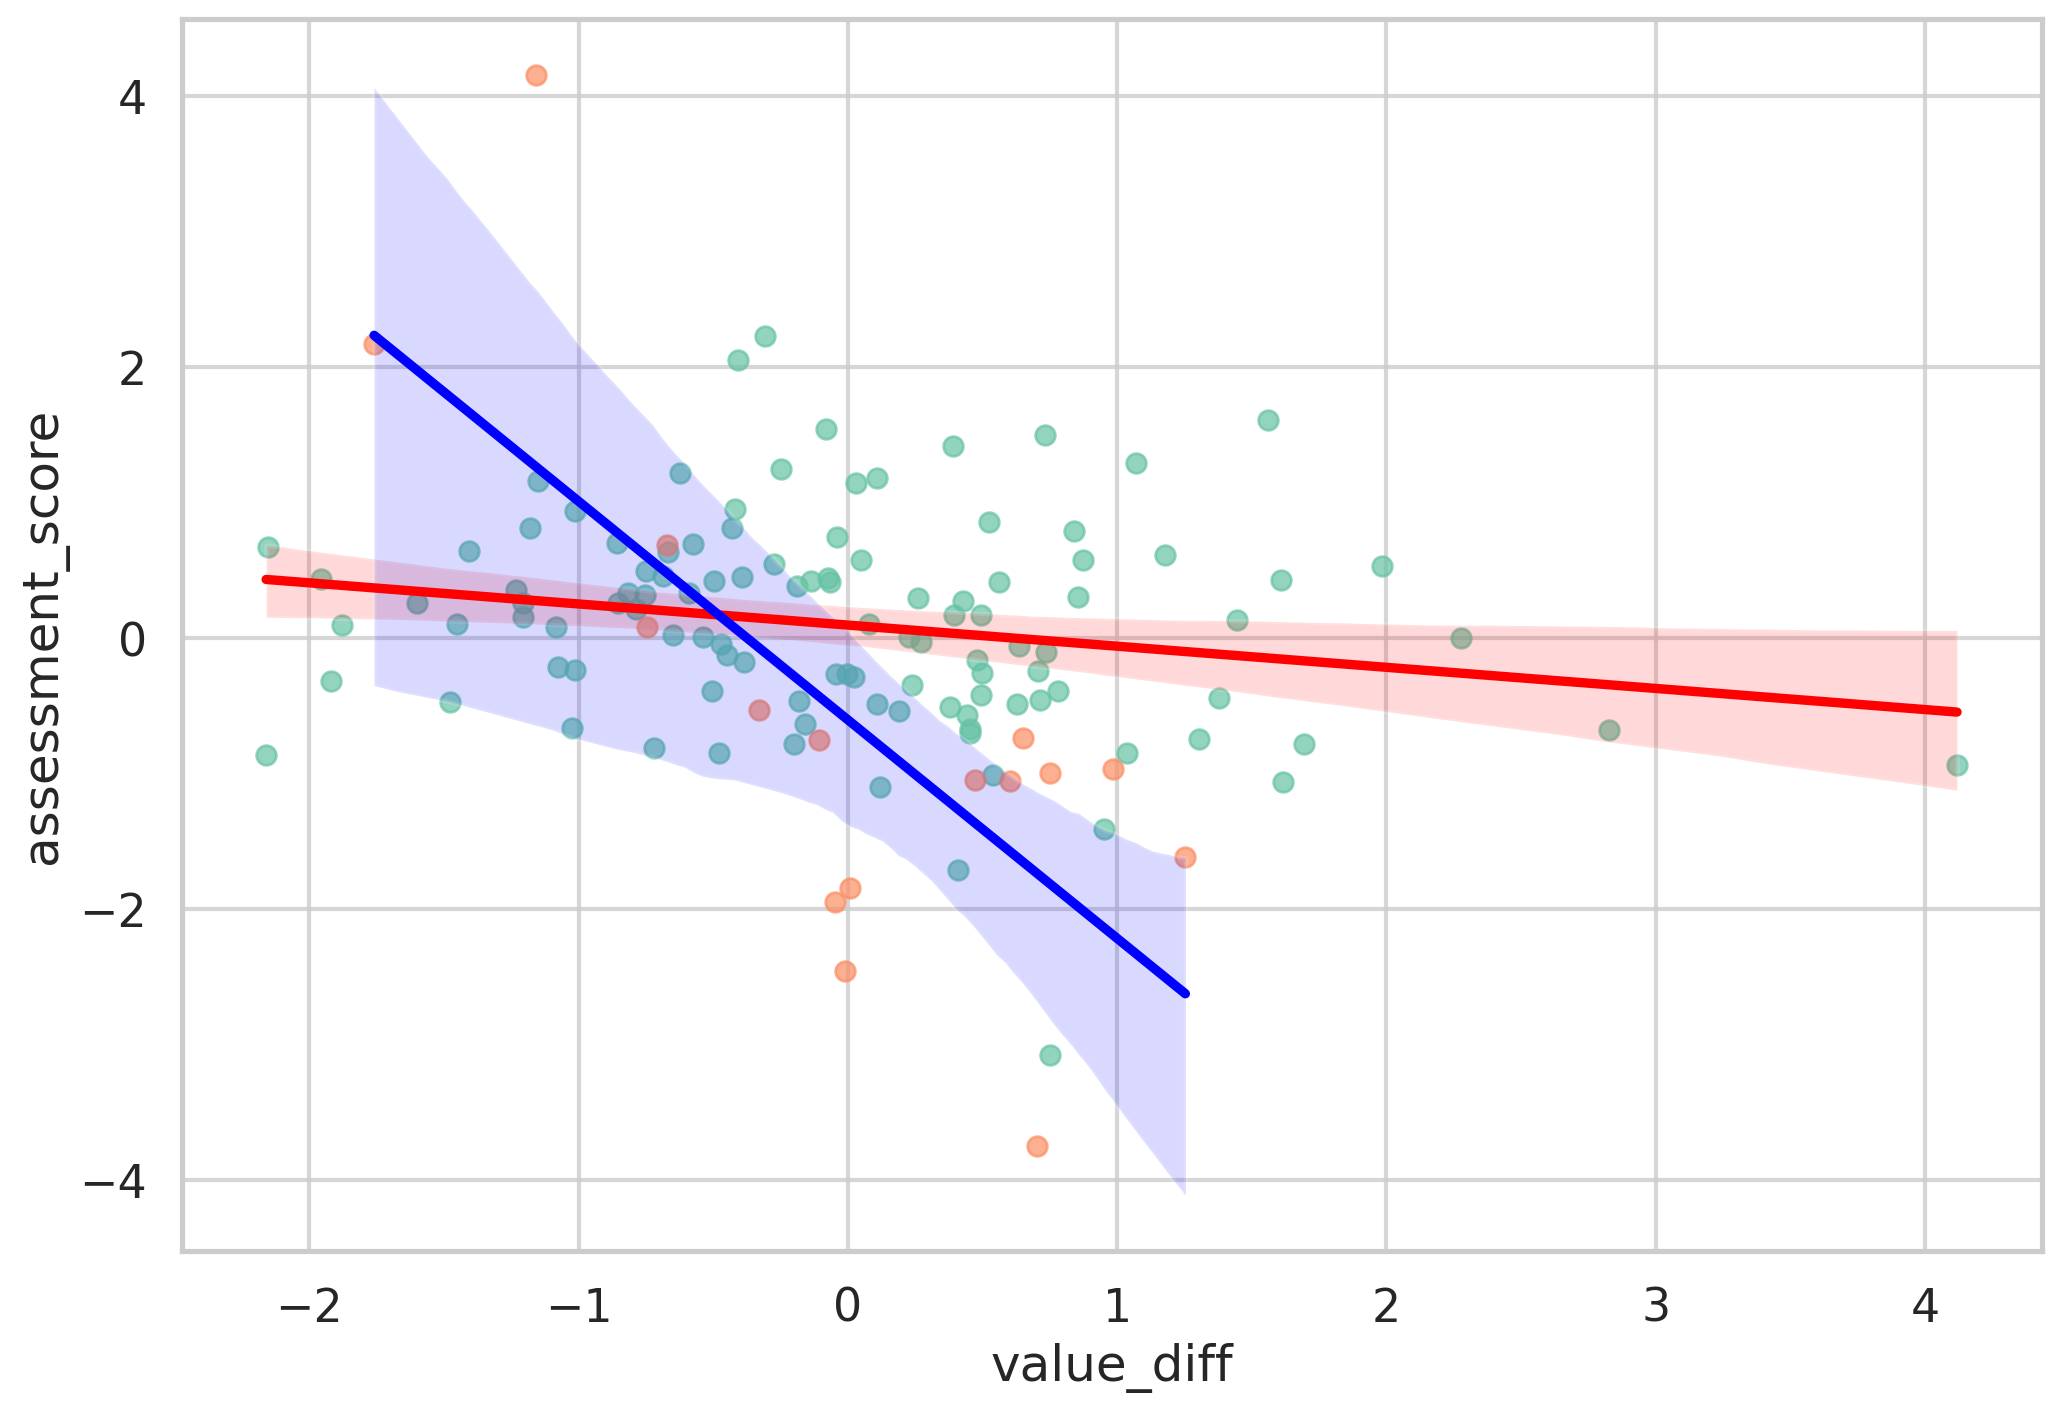

In [158]:
import seaborn as sns
sns.regplot(
    data=d_diff[d_diff["condition"] == "Learner"],
    x="value_diff",
    y="assessment_score",
    scatter_kws={"s": 50, "alpha": 0.7},
    line_kws={"color": "red"},
)
sns.regplot(
    data=d_diff[d_diff["condition"] == "Athlete"],
    x="value_diff",
    y="assessment_score",
    scatter_kws={"s": 50, "alpha": 0.7},
    line_kws={"color": "blue"},
)


In [160]:
import matplotlib.pyplot as plt

# visualize
metrics = ["gm_vol", "adc"]

value_column = "r_partial"
vmin = -5
vmax = 5

fdr_corrected = True
# sport = "all"
old_format = False

# for contrast in ["slope_learner_pre", "factor_learner_pre", "slope","slope_x_learner","factor","factor_x_learner","slope_interaction","factor_interaction","L_post","L_slope_month"]:
for contrast in [
    "LvA_interaction",
    "value_diff",
    # "LvA",
]:
    contrast_name = contrast.replace("_p", "_q") if old_format else contrast

    for metric in metrics:
        fdr_label = "fdr_corrected" if fdr_corrected else "uncorrected"
        # metric_dir = output_dir  / "passive" / sport / contrast / metric / fdr_label
        metric_dir = output_dir / metric / contrast / fdr_label
        metric_dir.mkdir(parents=True, exist_ok=True)
        vis_df = region_results[
            (region_results["metric"] == metric)
        ]

        vis_config = Fig1Config()
        vis_config.VMIN = vmin
        vis_config.VMAX = vmax

        #     break
        # break
        plotter = BrainPlotter(vis_config)

        plotter.plot_single_metric(
            results_df=vis_df,
            metric_key=f"{metric}_{contrast}",
            output_dir=metric_dir,
            p_column=f"{contrast_name}_q" if fdr_corrected else f"{contrast_name}_p",
            value_column=f"{contrast_name}_z",
        )
        plt.close("all")
        # break
    # break
# break

2025-09-08 15:18:16.703 | INFO     | athletes_brain.fig1.brain_visualization:plot_single_metric:276 - Creating brain plots for gm_vol_value_diff
2025-09-08 15:18:16.703 | INFO     | athletes_brain.fig1.brain_visualization:setup_surfaces:30 - Setting up brain surfaces and parcellations
2025-09-08 15:18:16.709 | SUCCESS  | athletes_brain.fig1.brain_visualization:setup_surfaces:39 - Brain surfaces and parcellations loaded successfully
2025-09-08 15:18:16.710 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:57 - Preparing value maps for value_diff_z
2025-09-08 15:18:16.740 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:97 - Prepared maps with 200 LH, 200 RH, and 54 subcortical regions
2025-09-08 15:18:16.740 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:121 - Creating cortical surface plots
2025-09-08 15:18:16.757 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:143 - Plotting left hemisp

In [82]:
vis_df[f"{contrast_name}_p"]

0      0.470006
1      0.133629
2      0.053505
3      0.171422
4      0.299504
         ...   
449    0.050730
450    0.842510
451    0.880180
452    0.538102
453    0.356815
Name: value_diff_p, Length: 454, dtype: float64

In [70]:
stats.sort_values("LvA_interaction_p").head(10)

,index,name,base_name,Label Name,network,component,hemisphere,LvA_est,LvA_se,LvA_z,...,LvA_interaction_hi,value_diff_est,value_diff_se,value_diff_z,value_diff_p,value_diff_lo,value_diff_hi,LvA_q,LvA_interaction_q,value_diff_q
358,359,7Networks_RH_Cont_Cing_2,7networks_rh_cont_cing,7Networks_RH_Cont_Cing,control,cingulate,R,1.038945,0.891698,1.165131,...,-0.211738,0.283897,0.046868,6.057431,1.383130e-09,0.192037,0.375758,0.245589,2.870384e-07,3.139704e-07
246,247,7Networks_RH_SomMot_17,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,3.850100,0.792108,4.860572,...,-0.095237,0.148444,0.023779,6.242727,4.300083e-10,0.101838,0.195051,0.000078,1.395964e-05,1.952238e-07
138,139,7Networks_LH_Cont_PFCl_5,7networks_lh_cont_pfcl,7Networks_LH_Cont_PFCl,control,lateral prefrontal cortex,L,3.188063,0.821579,3.880412,...,-0.108130,0.175372,0.031120,5.635274,1.747807e-08,0.114376,0.236368,0.000277,1.395964e-05,1.786240e-06
393,394,7Networks_RH_Default_pCunPCC_3,7networks_rh_default_pcunpcc,7Networks_RH_Default_pCunPCC,default,precuneus posterior cingulate cortex,R,3.534108,0.798815,4.424189,...,-0.196364,0.336235,0.057471,5.850540,4.899787e-09,0.223592,0.448877,0.000259,2.575287e-05,7.415012e-07
254,255,7Networks_RH_SomMot_25,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,3.059696,0.816627,3.746747,...,-0.090432,0.152047,0.027079,5.614859,1.967225e-08,0.098971,0.205122,0.000348,5.567256e-05,1.786240e-06
381,382,7Networks_RH_Default_PFCdPFCm_4,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,3.029023,0.830762,3.646076,...,-0.055618,0.092711,0.017529,5.289069,1.229403e-07,0.058355,0.127068,0.000453,5.723564e-05,9.302482e-06
343,344,7Networks_RH_Cont_PFCl_4,7networks_rh_cont_pfcl,7Networks_RH_Cont_PFCl,control,lateral prefrontal cortex,R,2.160141,0.885278,2.440071,...,-0.129943,0.228696,0.046026,4.968828,6.735892e-07,0.138485,0.318907,0.015326,1.626862e-04,3.822619e-05
174,175,7Networks_LH_Default_PFC_10,7networks_lh_default_pfc,7Networks_LH_Default_PFC,default,prefrontal cortex,L,3.239732,0.851146,3.806316,...,-0.074945,0.128963,0.028713,4.491486,7.072783e-06,0.072686,0.185240,0.000303,4.764112e-04,2.675870e-04
348,349,7Networks_RH_Cont_PFCl_9,7networks_rh_cont_pfcl,7Networks_RH_Cont_PFCl,control,lateral prefrontal cortex,R,1.832340,0.920278,1.991073,...,-0.103971,0.194388,0.040068,4.851433,1.225728e-06,0.115855,0.272922,0.047201,5.287297e-04,6.183118e-05
43,44,7Networks_LH_SomMot_13,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,2.014317,0.920815,2.187537,...,-0.088698,0.152198,0.034510,4.410255,1.032491e-05,0.084559,0.219838,0.029284,6.075801e-04,3.605778e-04


In [61]:
import seaborn as sns
m.summary()

# sns.scatterplot(data=d_diff, hue="condition", x="value_diff",y="assessment_score")
# d_diff

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       assessment_score   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     2.840
Date:                Mon, 08 Sep 2025   Prob (F-statistic):            0.00954
Time:                        14:27:12   Log-Likelihood:                -281.76
No. Observations:                 110   AIC:                             579.5
Df Residuals:                     102   BIC:                             601.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.2901      0.981      0.296      0.768      -1.656       2.237
C(condition)[T.Learner]                3.7476      0.965      3.884      0.000       1.834       5.661
C(sex)[T.1]                           -1.6695      0.903     -1.849      0.067      -3.460       0.121
value_diff                            -0.0017      0.007     -0.228      0.820      -0.016       0.013
value_diff:C(condition)[T.Learner]     0.0048      0.009      0.569      0.571      -0.012       0.022
age_c                                  0.0181      0.070      0.257      0.798      -0.121       0.157
age_c2                                -0.0045      0.006     -0.790      0.431      -0.016       0.007
tiv_z                                 -0.0926      0.439     -0.211      0.833      -0.964       0.779
==============================================================================
Omnibus:                       37.595   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.855
Skew:                           0.788   Prob(JB):                     3.11e-63
Kurtosis:                      10.767   Cond. No.                         479.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
m

'model'

In [32]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm


m = smf.ols("y ~ C(condition) * assessment_score", data=d_diff).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.2476
Date:                Mon, 08 Sep 2025   Prob (F-statistic):              0.863
Time:                        14:09:34   Log-Likelihood:                -643.70
No. Observations:                 110   AIC:                             1295.
Df Residuals:                     106   BIC:                             1306.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  -36.7480     22.163     -1.658      0.100     -80.689       7.193
C(condition)[T.Learner]                     13.5343     25.894      0.523      0.602     -37.804      64.872
assessment_score                            -1.1557      3.930     -0.294      0.769      -8.948       6.636
C(condition)[T.Learner]:assessment_score     2.4085      5.135      0.469      0.640      -7.773      12.590
==============================================================================
Omnibus:                       32.653   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.181
Skew:                          -1.118   Prob(JB):                     1.74e-17
Kurtosis:                       6.440   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""